In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split
import tensorflow as tf

import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from psutil import *
cpu_count()
!lscpu | grep 'Model name'
!df -h / |awk '{print $4}'
! free -h --si |awk '/Mem:/{print $2}'
!nvidia-smi -L
!nvidia-smi

Model name:                         Intel(R) Xeon(R) CPU @ 2.00GHz
Avail
2.7T
32G
GPU 0: Tesla T4 (UUID: GPU-072cae05-c04f-f1b6-e69d-865aeca4b42e)
GPU 1: Tesla T4 (UUID: GPU-556367f6-5000-27b7-71bc-20a67a3574fb)
Fri Dec 29 18:54:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |   

In [3]:
n = 3000000 #number of records in file
s = int(0.01*n )#desired sample size

random.seed(43)
header = pd.read_csv('/kaggle/input/hackaton/Question3_train.csv', nrows=0).columns.tolist()
train = pd.read_csv('/kaggle/input/hackaton/Question3_train.csv', skiprows=sorted(random.sample(range(n),n-s)), header=None, names=header)

train.describe()

,eventID,PID,momentum,theta,phi,X0,X1,X2,X3,X4,...,Z50,Z51,Z52,Z53,Z54,Z55,Z56,Z57,Z58,Z59
count,3.000100e+04,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,...,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,1.495177e+06,265.726842,17.509390,15.506358,2.519828,1319.605348,1320.191551,1320.015362,1320.112345,1320.291225,...,84.506806,64.993828,48.207765,33.981801,25.973333,18.849341,12.867479,8.454113,5.375078,3.426605
std,8.635005e+05,55.000238,1.445417,0.288861,1.439505,46.196226,35.920986,39.430472,35.827169,33.309754,...,434.822381,383.147926,331.214270,278.676530,244.172652,208.273326,172.592271,140.060098,112.011550,89.459786
min,1.500000e+01,211.000000,15.000014,15.000008,0.000091,-1677.943500,-1199.848800,-1326.476400,-687.610050,-762.793100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.401040e+05,211.000000,16.255941,15.257935,1.269008,1303.666500,1303.652500,1303.496000,1303.004800,1302.747400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.494584e+06,211.000000,17.516834,15.508560,2.529994,1320.716200,1321.057300,1320.825700,1320.387500,1320.354500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.240316e+06,321.000000,18.767925,15.756448,3.772101,1337.479100,1338.140100,1337.700900,1337.846700,1338.238800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.999999e+06,321.000000,19.999975,15.999872,4.999844,1751.555300,1712.667000,1690.443100,1691.727200,1717.617200,...,2448.800000,2449.980500,2449.002700,2449.927700,2449.848100,2449.908000,2443.653000,2449.916700,2449.460400,2448.333300


In [4]:
#pip install --upgrade pip


In [5]:
#pip install tables

In [6]:
df =pd.DataFrame({'eventID':[], 'PID':[], 'momentum':[], 'theta':[], 'phi':[], 'image':[] })
df  = df.astype('object')

length = train.shape[0]
print(length)


for ii in range(0,length):
    event =train.iloc[ii]
    x = [event[f"X{i}"]*2300/event[f"Z{i}"] for i in range(0, 60) if event[f"X{i}"] != 0.0]
    y = [event[f"Y{i}"]*2300/event[f"Z{i}"] for i in range(0, 60) if event[f"Y{i}"] != 0.0]

    PionKaon  = 0 if event["PID"] == 211 else 1
    counts, binsx, binsy = np.histogram2d(x, y, bins=(np.linspace(1000, 1600,65),np.linspace(-500, 500,65)))


    df.loc[ii] = [event["eventID"], PionKaon, event["momentum"], event["theta"], event["phi"], counts]


df.head()

30001


,eventID,PID,momentum,theta,phi,image
0,15.0,0,15.262166,15.353178,0.913694,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,307.0,0,17.091219,15.118875,0.190871,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,387.0,1,19.993956,15.181416,2.966388,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,392.0,0,19.816440,15.221616,2.138805,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,454.0,0,15.801785,15.188346,3.536139,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


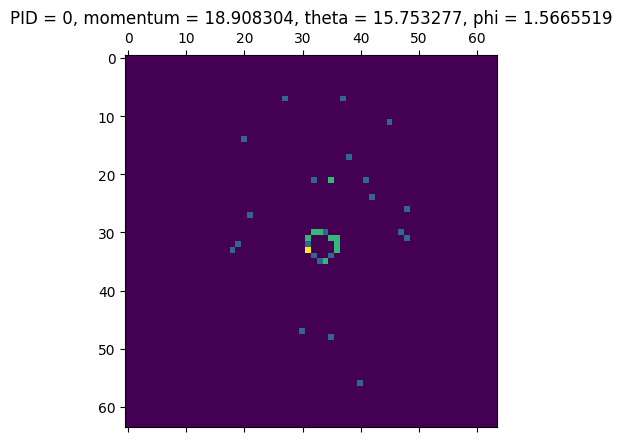

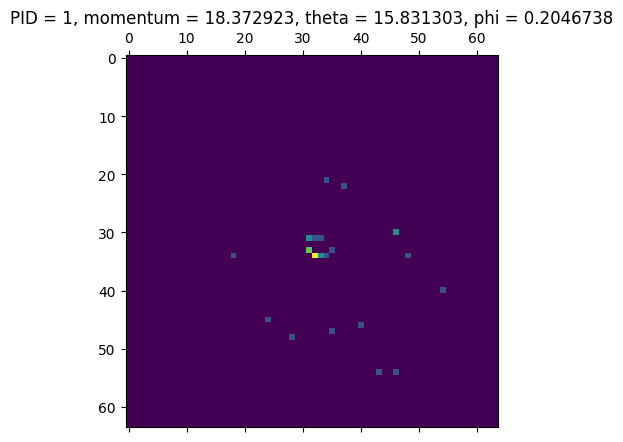

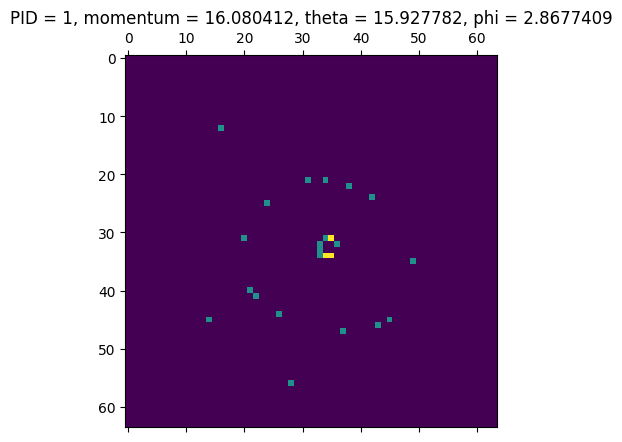

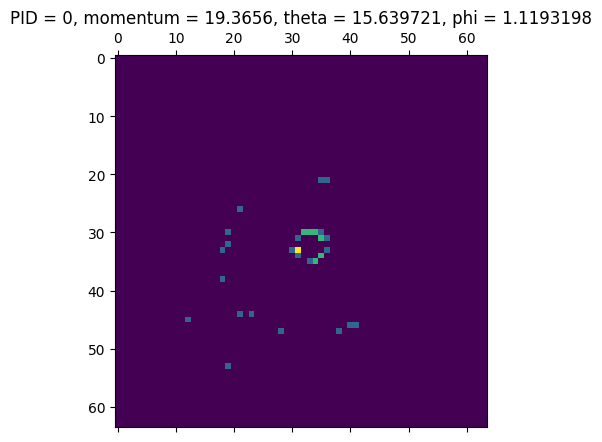

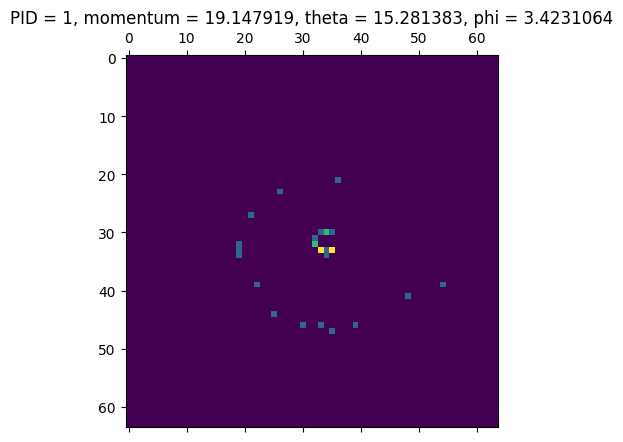

In [7]:
for i in random.sample(range(length),5):
    plt.matshow(df.loc[i,"image"])
    plt.title(f'PID = {df.loc[i,"PID"]}, momentum = {df.loc[i,"momentum"]}, theta = {df.loc[i,"theta"]}, phi = {df.loc[i,"phi"]}')

# Building a CNN

In [8]:
images = np.stack(df['image'].to_numpy()).reshape(length,64,64)
print(images.shape)

k1 = np.stack((df['momentum']/df['momentum'].max()).to_numpy()).reshape(length,1)
k2 = np.stack((df['theta']/df['theta'].max()).to_numpy()).reshape(length,1)
k3 = np.stack((df['phi']/df['phi'].max()).to_numpy()).reshape(length,1)

kinematics = np.concatenate((k1,k2,k3),axis=1)
print(kinematics.shape)

labels = np.array(df["PID"]).reshape(length,1)
print(labels.shape)

concat = np.concatenate((kinematics,labels),axis=1)
print(concat.shape)

(30001, 64, 64)
(30001, 3)
(30001, 1)
(30001, 4)


In [9]:
testsize=0.2
X_train, X_test, y_train, y_test = train_test_split(images, concat, test_size=testsize, random_state=421)

In [10]:
XX_train = [X_train, y_train[:, 0:3].reshape(  int(length*(1-testsize))  ,3 )] 
XX_test = [X_test, y_test[:, 0:3].reshape(  int(length*(testsize)+1)  ,3 )] 
yy_train = y_train[:, 3].reshape(  int(length*(1-testsize))  ,1 )
yy_test = y_test[:, 3].reshape(  int(length*(testsize)+1)  ,1 )

print(yy_train.shape)
print(yy_train.shape)

(24000, 1)
(24000, 1)


### CNN model from Keras Sequantial API

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(2, 2), input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(filters = 8,kernel_size =(5,5),strides=(1, 1)),
    tf.keras.layers.Conv2D(filters = 16,kernel_size =(7,7),strides=(2, 2)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 1, activation='sigmoid')
    ])

model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 68, 68, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         208       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 16)        6288      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 1)                 3

### Kears Functional API

In [12]:
input_img = tf.keras.Input(shape=(64,64,1))
Layer1 = tf.keras.layers.ZeroPadding2D(padding=(2, 2))(input_img)
Layer2 = tf.keras.layers.Conv2D(filters = 8,kernel_size =(5,5),strides=(1, 1))(Layer1)
Layer3 = tf.keras.layers.Conv2D(filters = 16,kernel_size =(7,7),strides=(2, 2))(Layer2)
Layer4 = tf.keras.layers.MaxPool2D()(Layer3)
Layer5 = tf.keras.layers.Flatten()(Layer4)
outputs = tf.keras.layers.Dense(units = 1, activation='sigmoid')(Layer5)


model = tf.keras.Model(inputs=input_img, outputs=outputs)


model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 68, 68, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 8)         208       
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 16)        6288      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0     

## Model with multiple inputs from Keras

In [13]:
input_img = tf.keras.Input(shape=(64,64,1))
input_kinemat = tf.keras.Input(shape=(3,))

# Layer for the image
Layer1 = tf.keras.layers.ZeroPadding2D(padding=(2, 2))(input_img)
Layer2 = tf.keras.layers.Conv2D(filters = 8,kernel_size =(5,5),strides=(1, 1))(Layer1)
Layer3 = tf.keras.layers.Conv2D(filters = 16,kernel_size =(7,7),strides=(2, 2))(Layer2)
Layer4 = tf.keras.layers.MaxPool2D()(Layer3)
Layer5 = tf.keras.layers.Flatten()(Layer4)
output_img = tf.keras.layers.Dense(units = 32, activation='relu')(Layer5)

# Layer for the kinematics
LayerI = tf.keras.layers.Dense(units = 5, activation='relu')(input_kinemat)
LayerII = tf.keras.layers.Dense(units = 3, activation='relu')(LayerI)
output_kinemat = tf.keras.layers.Dense(units = 2, activation='relu')(LayerII)


# combine the output of the two branches
combined = tf.keras.layers.Concatenate(axis=1)([output_img, output_kinemat])

z1 = tf.keras.layers.Dense(units = 16, activation='relu')(combined)
outputs = tf.keras.layers.Dense(units = 1, activation='sigmoid')(z1)



model = tf.keras.Model(inputs= [input_img,input_kinemat], outputs=outputs)

model.compile(
    'adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
    )

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 68, 68, 1)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_4 (Conv2D)           (None, 64, 64, 8)            208       ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv2d_5 (Conv2D)           (None, 29, 29, 16)           6288      ['conv2d_4[0][0]']      

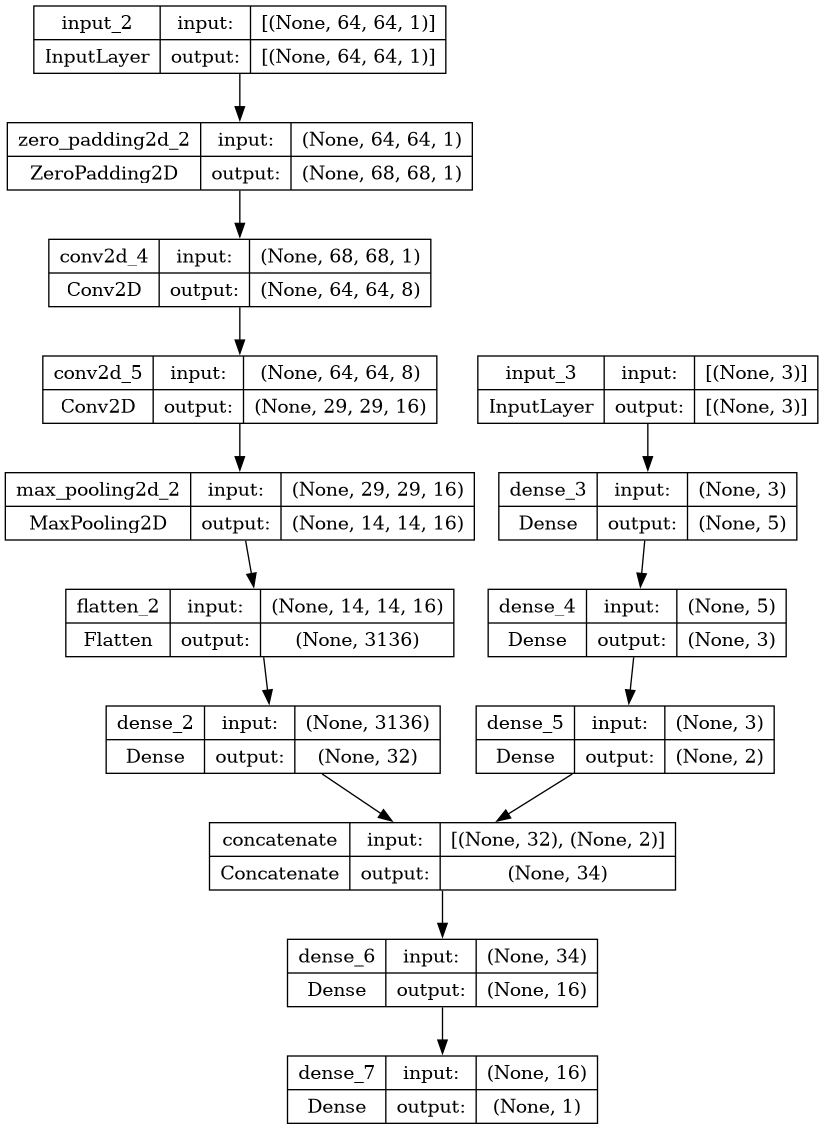

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,rankdir ='TB')

In [15]:
history = model.fit(XX_train, yy_train, epochs=15, batch_size=1024, validation_data=(XX_test, yy_test))

Epoch 1/15
24/24 [==============================] - 15s 110ms/step - loss: 0.3905 - accuracy: 0.9068 - val_loss: 0.1254 - val_accuracy: 0.9587
Epoch 2/15
24/24 [==============================] - 1s 50ms/step - loss: 0.0852 - accuracy: 0.9728 - val_loss: 0.0626 - val_accuracy: 0.9830
Epoch 3/15
24/24 [==============================] - 1s 50ms/step - loss: 0.0514 - accuracy: 0.9855 - val_loss: 0.0445 - val_accuracy: 0.9890
Epoch 4/15
24/24 [==============================] - 1s 50ms/step - loss: 0.0367 - accuracy: 0.9900 - val_loss: 0.0377 - val_accuracy: 0.9903
Epoch 5/15
24/24 [==============================] - 1s 50ms/step - loss: 0.0302 - accuracy: 0.9925 - val_loss: 0.0337 - val_accuracy: 0.9913
Epoch 6/15
24/24 [==============================] - 1s 50ms/step - loss: 0.0268 - accuracy: 0.9928 - val_loss: 0.0312 - val_accuracy: 0.9920
Epoch 7/15
24/24 [==============================] - 1s 51ms/step - loss: 0.0242 - accuracy: 0.9937 - val_loss: 0.0301 - val_accuracy: 0.9918
Epoch 8/15


/tmp/ipykernel_26/2330178472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_26/2330178472.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

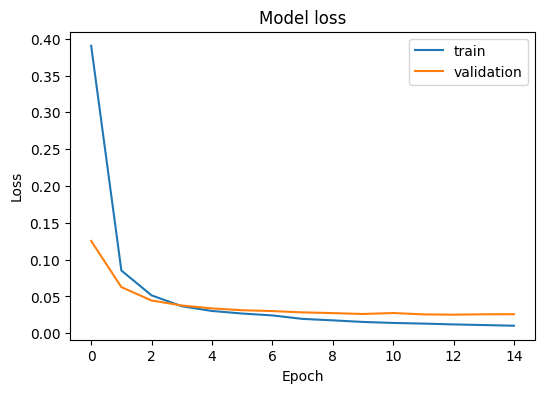

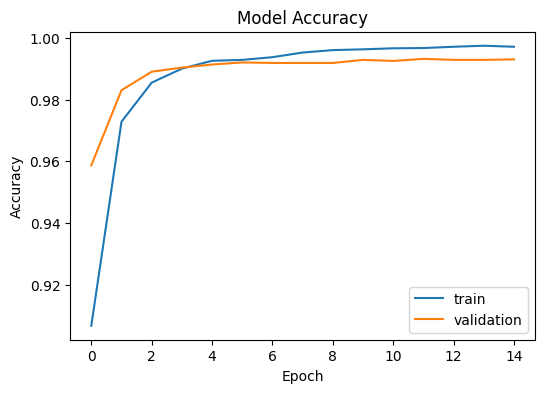

In [16]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on.
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')